# Trabalho T2: DDPG Portfolio Management

Neste trabalho vamos treinar um robô trader utilizando uma adaptação do trabalho do AI4Finance a partir do seguinte github

https://github.com/AI4Finance-LLC/FinRL

**Objetivo do trabalho**: Criação de agente DDPG com biblioteca keras-rl2 e treinamento em ambiente FinRL para tarefa de *portfolio management* de 15 ações entre as mais negociadas na bolsa brasileira no período entre 2008 e 2020.

**O que o agente faz**: O agente escolhe como alocar os recursos entre as 15 ações escolhidas, com uma porcetagem de alocação para cada ação. Assim, trata-se de um problema de ações contínuas, no qual métodos *Value-Based* não poderiam ser aplicados.

**Separação entre teste e treino**: O agente deve ser treinado com os dados entre 2008 e 2018 e testado com os dados entre 2019 e 2020.

**Lembrando**: está é uma simplificação de um modelo real. Lembre que há taxas (de corretagem), impostos, cálculos de risco (como sharpe ratio que mostra que nem sempre mais rentabilidade significa o melhor resultado) e muitas outras complexidades envolvidas numa aplicação real. Recomendamos a quem tiver interesse estudar diversas aplicações e inclusive os 4 papers disponibilizados pela AI4Finance para aplicação online reais. Mas, apesar de tudo isso, é possível notar o poder dos algoritmos de aprendizado por reforço no auxílio da pratica de trading.

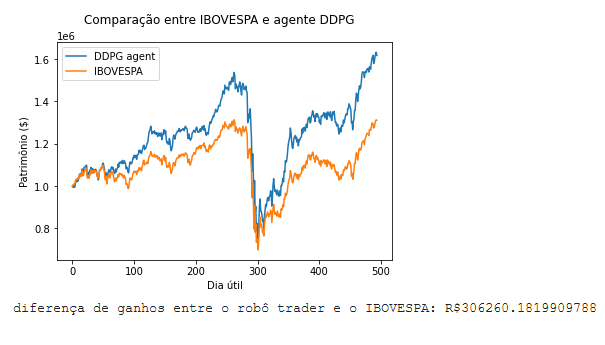

In [1]:
## install finrl library
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git
!pip install keras-rl2

  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-t35yucf1
  Running command git clone -q https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-t35yucf1
     |████████████████████████████████| 153kB 27.9MB/s 
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-72u7vmp2/pyfolio
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-72u7vmp2/pyfolio
     |████████████████████████████████| 6.3MB 39.1MB/s 
     |████████████████████████████████| 61kB 8.6MB/s 
  Created wheel for finrl: filename=finrl-0.3.0-cp37-none-any.whl size=38749 sha256=bde3e05b76a74c2387ba63e27b3ade35073eb8ea0c8fa28ee4a8364376631ffe
  Stored in directory: /tmp/pip-ephem-wheel-cache-v0th_4nx/wheels/9c/19/bf/c644def96612df1ad42c94d5304966797eaa3221dffc5efe0b
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23442 sha256=bd52e7b72b3541cc15f8346921bc82896416328191d19723abefdd6b60c0233a


## Imports

In [2]:
# General Imports
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime

# finRL Imports
from finrl.config import config
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.env.env_portfolio import StockPortfolioEnv
from finrl.model.models import DRLAgent
from finrl.trade.backtest import backtest_stats, backtest_plot, get_daily_return, get_baseline,convert_daily_return_to_pyfolio_ts
import sys
sys.path.append("../FinRL-Library")

# gym Imports
from gym.utils import seeding
import gym
from gym import spaces
matplotlib.use('Agg')

# Tensorflow Imports
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Input, Concatenate
from tensorflow.keras.optimizers import Adam

# keras-rl Imports
from rl.agents import DDPGAgent
from rl.memory import SequentialMemory
from rl.random import OrnsteinUhlenbeckProcess

/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


## Lista de Ações

Foram escolhidas 15 das ações mais negociadas entre 2008 e 2020. É possível testar com outro conjunto (inclusive ações de outros países)

In [3]:
ACOES_BR_15 = ["PETR4.SA",
               "VALE3.SA",
               "CSAN3.SA",
               "USIM5.SA",
               "VVAR3.SA",
               "LREN3.SA",
               "BBDC4.SA",
               "ITUB4.SA",
               "BBAS3.SA",
               "ABEV3.SA",
               "GGBR4.SA",
               "BRFS3.SA",
               "RENT3.SA",
               "CMIG4.SA",
               "JBSS3.SA"
]

## Obter Dataset Yahoo

Utilizando a API do YAHOO para realizar o download dos dados dessas ações

In [4]:
df = YahooDownloader(start_date = '2008-01-01',
                     end_date = '2021-01-01',
                     ticker_list = ACOES_BR_15).fetch_data()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

### Processamento de indicadores

Com o objetivo , seguintes features
*   macd - moving average convergence divergence: de acordo com o wikipedia "MACD significa Moving Average Convergence / Divergence (Convergência e Divergência de Médias Móveis) e é um indicador bastante popular na análise técnica. Foi criado por Gerald Appel na década de 60 e mostra a diferença entre dois sinais, um rápido e um lento, gerados a partir do movimento das Médias Móveis Exponenciais (MME) no gráfico. "


*   boll_ub - Bollinger upper band e boll_lb - Bollinger lower band: de acordo com o Wikipedia "Análise de Bollinger (também conhecida como Bandas de Bollinger) são ferramentas de análise técnica criadas por John Bollinger no início dos anos 80. Este indicador possui uma forte relação com a volatilidade, possibilitando, assim, a sua comparação com os níveis de preços num determinado período de tempo. O maior objetivo das bandas Bollinger é fornecer uma ideia relativa de alto e baixo. Por definição, os preços são altos na linha (banda) superior e baixos na linha (banda) inferior."  


*   rsi_30 - Relative strength index: de acordo com o wikipedia "O Índice de força relativa ou IFR mede a aceleração do movimento dos preços de determinado ativo e dá suas indicações à medida que o movimento diminui a velocidade, dentro da idéia de que é preciso desacelerar para poder mudar de direção. Para medir esta aceleração J. Welles Wilder em seu livro New Concepts in Technical Trading Systems (1978) desenvolveu o conceito de Força Relativa que é monitorar as mudanças nos preços de fechamento. Seu acompanhamento muitas vezes possibilita observar o enfraquecimento de uma tendência, rompimentos, suporte e resistência antes de se tornarem aparentes."

É definido pela seguinte fórmula: 

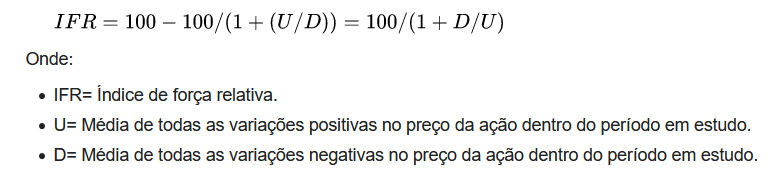


*   cci_30 - Commodity channel index: este indicador traz informações sobre o comportamento cíclico (no caso 30, dos últimos 30 dias) e é definido pela seguinte fórmula: 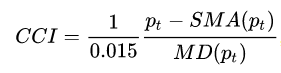

Sendo p_t o preço típico (média simples entre o preço máximo, o preço mínimo e o preço de fechamento), SMA é a média móvel simples dos p_t e MD é a média dos desvios padrões absolutos.

*   dx_30 - Average Directional Movement Index: de acordo com o Wikipedia: "O índice de movimento direcional médio (ADX) foi desenvolvido em 1978 por J. Welles Wilder como um indicador da força da tendência em uma série de preços de um instrumento financeiro. O ADX se tornou um indicador amplamente usado por analistas técnicos e é fornecido como um padrão em coleções de indicadores oferecidos por várias plataformas de negociação. "


*   close_30_sma: Média móvel simples do preço de fechamento calculada nos últimos 30 dias


*   close_60_sma: Média móvel simples do preço de fechamento calculada nos últimos 60 dias

In [5]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    use_turbulence=False,
                    user_defined_feature = False)

df = fe.preprocess_data(df)

Successfully added technical indicators


In [6]:
df.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,2008-01-02,4.994394,4.994394,4.788625,3.162840,387934.0,ABEV3.SA,2,0.0,3.18499,3.152261,100.0,66.666667,100.0,3.162840,3.162840
3222,2008-01-02,30.100000,30.820000,29.250000,14.184918,4728300.0,BBAS3.SA,2,0.0,3.18499,3.152261,100.0,66.666667,100.0,14.184918,14.184918
6444,2008-01-02,23.535587,23.635349,21.989271,14.076235,0.0,BBDC4.SA,2,0.0,3.18499,3.152261,100.0,66.666667,100.0,14.076235,14.076235
9666,2008-01-02,21.740000,22.299999,21.100000,18.829924,1539200.0,BRFS3.SA,2,0.0,3.18499,3.152261,100.0,66.666667,100.0,18.829924,18.829924
12888,2008-01-02,12.145106,12.145106,12.145106,4.811455,0.0,CMIG4.SA,2,0.0,3.18499,3.152261,100.0,66.666667,100.0,4.811455,4.811455


### Adição de Matrix de Covariância como estado

Criar uma matriz de covariância entre as variações dos preços de fechamento das ações. Isso ajuda o agente uma vez que há uma forte correlação entre as ações de um mesmo país

In [7]:
# add covariance matrix as states
df=df.sort_values(['date','tic'],ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
# look back is one year
lookback=252
for i in range(lookback,len(df.index.unique())):
  data_lookback = df.loc[i-lookback:i,:]
  price_lookback=data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
  return_lookback = price_lookback.pct_change().dropna()
  covs = return_lookback.cov().values 
  cov_list.append(covs)
  
df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date','tic']).reset_index(drop=True)

### Separação do Dataset de Treino

In [8]:
train = data_split(df, '2009-01-01','2019-01-01')


In [9]:
train.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list
0,2009-01-07,3.356233,3.435344,3.356233,2.236079,450505.0,ABEV3.SA,2,0.016251,2.396094,2.094934,50.289530,39.571557,3.315211,2.207858,2.185564,"[[0.0007515567107331648, 0.0005504281533343221..."
0,2009-01-07,15.890000,15.950000,15.450000,7.501820,1807700.0,BBAS3.SA,2,0.055131,8.147853,6.496882,49.836101,65.270554,20.523884,7.051838,7.009632,"[[0.0007515567107331648, 0.0005504281533343221..."
0,2009-01-07,14.166245,14.166245,14.166245,9.233919,0.0,BBDC4.SA,2,-0.143857,10.830719,8.738705,46.101707,-59.064896,16.884492,9.618719,9.587286,"[[0.0007515567107331648, 0.0005504281533343221..."
0,2009-01-07,15.705000,15.800000,15.330000,14.072527,1253600.0,BRFS3.SA,2,-0.369916,17.056327,12.864718,46.045276,-107.325397,18.072018,15.090263,14.603143,"[[0.0007515567107331648, 0.0005504281533343221..."
0,2009-01-07,11.558054,11.741502,11.429622,4.590502,2142967.0,CMIG4.SA,2,-0.121030,5.206486,4.285310,45.798784,-77.377921,10.380550,4.935159,4.887530,"[[0.0007515567107331648, 0.0005504281533343221..."


## StockPortfolioEnv Environment Class

Definição da classe do ambiente que é uma simplificação de um dos environments da biblioteca finrl

In [10]:
class StockPortfolioEnv(gym.Env):
    """A single stock trading environment for OpenAI gym

    Attributes
    ----------
        df: DataFrame
            input data
        stock_dim : int
            number of unique stocks
        initial_amount : int
            start money
        reward_scaling: float
            scaling factor for reward, good for training
        state_space: int
            the dimension of input features
        action_space: int
            equals stock dimension
        tech_indicator_list: list
            a list of technical indicator names
        turbulence_threshold: int
            a threshold to control risk aversion
        day: int
            an increment number to control date

    Methods
    -------
    _sell_stock()
        perform sell action based on the sign of the action
    _buy_stock()
        perform buy action based on the sign of the action
    step()
        at each step the agent will return actions, then 
        we will calculate the reward, and return the next observation.
    reset()
        reset the environment
    render()
        use render to return other functions
    save_asset_memory()
        return account value at each time step
    save_action_memory()
        return actions/positions at each time step
        

    """
    metadata = {'render.modes': ['human']}

    def __init__(self, 
                df,
                stock_dim,
                initial_amount,
                reward_scaling,
                state_space,
                action_space,
                tech_indicator_list,
                turbulence_threshold=None,
                lookback=252,
                day = 0):
        #super(StockEnv, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.lookback=lookback
        self.df = df
        self.stock_dim = stock_dim
        self.initial_amount = initial_amount
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list

        # action_space normalization and shape is self.stock_dim
        self.action_space = spaces.Box(low = 0, high = 1,shape = (self.action_space,)) 
        # Shape = (34, 30)
        # covariance matrix + technical indicators
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (self.state_space+len(self.tech_indicator_list),self.state_space))

        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.terminal = False     
        self.turbulence_threshold = turbulence_threshold        
        # initalize state: inital portfolio return + individual stock return + individual weights
        self.portfolio_value = self.initial_amount

        # memorize portfolio value each step
        self.asset_memory = [self.initial_amount]
        # memorize portfolio return each step
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]]

        
    def step(self, actions):
        # print(self.day)
        self.terminal = self.day >= len(self.df.index.unique())-1
        # print(actions)

        if self.terminal:
            df = pd.DataFrame(self.portfolio_return_memory)
            df.columns = ['daily_return']

            print("=================================")
            print("begin_total_asset:{}".format(self.asset_memory[0]))           
            print("end_total_asset:{}".format(self.portfolio_value))

            df_daily_return = pd.DataFrame(self.portfolio_return_memory)
            df_daily_return.columns = ['daily_return']
            if df_daily_return['daily_return'].std() !=0:
              sharpe = (252**0.5)*df_daily_return['daily_return'].mean()/ \
                       df_daily_return['daily_return'].std()
              print("Sharpe: ",sharpe)
            print("=================================")
            
            return self.state, self.reward, self.terminal,{}

        else:
            #print("Model actions: ",actions)
            # actions are the portfolio weight
            # normalize to sum of 1
            #if (np.array(actions) - np.array(actions).min()).sum() != 0:
            #  norm_actions = (np.array(actions) - np.array(actions).min()) / (np.array(actions) - np.array(actions).min()).sum()
            #else:
            #  norm_actions = actions
            weights = self.softmax_normalization(actions) 
            #print("Normalized actions: ", weights)
            self.actions_memory.append(weights)
            last_day_memory = self.data

            #load next state
            self.day += 1
            self.data = self.df.loc[self.day,:]
            self.covs = self.data['cov_list'].values[0]
            self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
            #print(self.state)
            # calcualte portfolio return
            # individual stocks' return * weight
            portfolio_return = sum(((self.data.close.values / last_day_memory.close.values)-1)*weights)
            # update portfolio value
            new_portfolio_value = self.portfolio_value*(1+portfolio_return)
            old_portifolio_value = self.portfolio_value
            self.portfolio_value = new_portfolio_value

            # save into memory
            self.portfolio_return_memory.append(portfolio_return)
            self.date_memory.append(self.data.date.unique()[0])            
            self.asset_memory.append(new_portfolio_value)

            # the reward is the new portfolio value or end portfolo value
            self.reward = (new_portfolio_value - old_portifolio_value)
            #print("Step reward: ", self.reward)
            self.reward = self.reward*self.reward_scaling

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [self.initial_amount]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        # load states
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.portfolio_value = self.initial_amount
        #self.cost = 0
        #self.trades = 0
        self.terminal = False 
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]] 
        return self.state
    
    def render(self, mode='human'):
        return self.state
        
    def softmax_normalization(self, actions):
        numerator = np.exp(actions)
        denominator = np.sum(np.exp(actions))
        softmax_output = numerator/denominator
        return softmax_output

    
    def save_asset_memory(self):
        date_list = self.date_memory
        portfolio_return = self.portfolio_return_memory
        #print(len(date_list))
        #print(len(asset_list))
        df_account_value = pd.DataFrame({'date':date_list,'daily_return':portfolio_return})
        return df_account_value

    def save_action_memory(self):
        # date and close price length must match actions length
        date_list = self.date_memory
        df_date = pd.DataFrame(date_list)
        df_date.columns = ['date']
        
        action_list = self.actions_memory
        df_actions = pd.DataFrame(action_list)
        df_actions.columns = self.data.tic.values
        df_actions.index = df_date.date
        #df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]


In [11]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 15, State Space: 15


### Tarefa a) Criação de ambiente StockPortfolioEnv

Crie um ambiente StockPortfolioEnv com o comando **e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)**, onde **kwargs é um dicionário do tipo:

**env_kwargs = {
    "initial_amount": P_0, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
}**

Inicialize o ambiente com patrimônio inicial de R$1.000.000


In [12]:
env_kwargs = { "initial_amount":1000000, "state_space": state_space, "stock_dim": stock_dimension, "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, "action_space": stock_dimension, "reward_scaling": 1e-4 }
e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)

In [13]:
e_train_gym.action_space

Box(0.0, 1.0, (15,), float32)

## Criação de Agente DDPG

Vamos agora definir os modelos keras utilizados pelo ator e crítico de nosso agente DDPG

In [14]:
nb_actions = e_train_gym.action_space.shape[0]

### Tarefa b) criação de modelos de agente $\pi_\theta$ e crítico $Q_w$

Implemente dois modelos de redes neurais do Keras para aproximação das funções $\pi_\theta$ e $Q_w$ conforme indicado abaixo.
Utilize as funções **actor.summary()** e **critic.summary()** para visualização dos modelos.

#### Actor model

Para representar a função $\pi_\theta(s)$, implemente uma rede neural do tipo MLP utilizando função  **Sequential()** do keras com:
*    Um *input layer* **Flatten(input_shape=(1,) + e_train_gym.observation_space.shape)**
*    Dois *hidden layers* de 400 e 300 neurônios respectivamente, com funções de ativação 'relu'
*    Um *output layer* com **nb_actions** neurônios e função de ativação 'sigmoid'.

In [15]:
# Actor Model

actor = Sequential()
actor.add( Flatten(input_shape=(1,) + e_train_gym.observation_space.shape) )
actor.add( Dense( 400 ) )
actor.add( Activation( 'relu' ) )
actor.add( Dense( 300 ) )
actor.add( Activation( 'relu' ) )
actor.add( Dense( nb_actions ) )
actor.add( Activation( 'sigmoid' ) )
print(actor.summary())

print(actor.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 345)               0         
_________________________________________________________________
dense (Dense)                (None, 400)               138400    
_________________________________________________________________
activation (Activation)      (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               120300    
_________________________________________________________________
activation_1 (Activation)    (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 15)                4515      
_________________________________________________________________
activation_2 (Activation)    (None, 15)                0

#### Critic model

Para representar a função $Q_w(s,a)$, implemente as camadas finais do modelo com:
*    Um *hidden layer* de 300 neurônios com função de ativação 'relu'
*    Uma camada de saída com função de ativação linear e apenas um neurônio
*   Por fim utilize a função **Model** do keras e com argumentos **inputs=** uma lista com **action_input** e **observation_input** e **outputs** como a última camada **x**

Caso haja dúvida na criação do modelo, é possível verificar o exemplo de aula do DDPG alterando a rede neural.



In [16]:
# Critic Model
action_input = Input(shape=(nb_actions,), name='action_input')
observation_input = Input(shape=(1,) + e_train_gym.observation_space.shape, name='observation_input')
flattened_observation = Flatten()(observation_input)
x = Dense(400)(flattened_observation)
x = Activation('relu')(x)
x = Concatenate()([x, action_input])


x = Dense( 300 )(x)
x = Activation( 'relu' )(x)
x = Dense( 1 )(x)
x = Activation( 'linear' )(x)
critic = Model( inputs=[action_input, observation_input], outputs=x )
print(critic.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
observation_input (InputLayer)  [(None, 1, 23, 15)]  0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 345)          0           observation_input[0][0]          
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 400)          138400      flatten_1[0][0]                  
__________________________________________________________________________________________________
activation_3 (Activation)       (None, 400)          0           dense_3[0][0]                    
______________________________________________________________________________________________

### Tarefa c) Criação e Compilação de agente

Vamos agora criar e compilar um agente DDPG de acordo com a biblioteca keras-rl2.

*   Inicialize um Experience Replay de tamanho limit=15000
*   Crie um processo aleatório do tipo "Ornstein-Uhlenbeck" com a função **random_process = OrnsteinUhlenbeckProcess(size=nb_actions, theta=.15, mu=0., sigma=.1)**

*   Em seguida, crie o agente DDPG com a classe **DDPGAgent** e os seguintes parâmetros:

        *   nb_steps_warmup_actor = 1000, 
        *   nb_steps_warmup_critic=1000
        *   gamma = 0.99
        *   target_model_update = 1e-3
        *   critic_action_input=action_input, onde action_input é a camada de entrada do modelo keras do Critic correspondente às ações tomadas pelo agente.


*   Por fim *compile* o agente usando o otimizador **Adam** com *learning rate* lr = 0.001 e **mean_squared_error** como única métrica


In [17]:
# Finally, we configure and compile our agent. You can use every built-in tensorflow.keras optimizer and
# even the metrics!

memory = SequentialMemory(limit=15000, window_length=1)
random_process = OrnsteinUhlenbeckProcess(size=nb_actions, theta=.15, mu=0., sigma=.1)
agent = DDPGAgent(nb_actions=nb_actions, actor=actor, critic=critic, critic_action_input=action_input,
                  memory=memory, nb_steps_warmup_critic=1000, nb_steps_warmup_actor=1000,
                  random_process=random_process, gamma=.99, target_model_update=1e-3)
agent.compile(Adam(lr=.001), metrics=['mse'])

Adam


## Tarefa d) Treino de agente DDPG

Implemente o treino do agente DDPG por 50000 timesteps por meio da função **agent.fit(e_train_gym, nb_steps, visualize=False, verbose=2)**

In [18]:
agent.fit(e_train_gym, nb_steps=50000, visualize=True, verbose=2)

Training for 50000 steps ...


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


begin_total_asset:1000000
end_total_asset:4895387.038345641
Sharpe:  0.7806606474347312
  2476/50000: episode: 1, duration: 19.174s, episode steps: 2476, steps per second: 129, episode reward: 402.502, mean reward:  0.163 [-36.003, 24.352], mean action: 0.519 [-0.491, 1.441],  loss: 4.982449, mse: 9.964898, mean_q: 0.030003
begin_total_asset:1000000
end_total_asset:6045458.011458584
Sharpe:  0.8942704036788501
  4952/50000: episode: 2, duration: 23.641s, episode steps: 2476, steps per second: 105, episode reward: 520.892, mean reward:  0.210 [-43.517, 30.887], mean action: 0.491 [-0.153, 0.886],  loss: 6.643230, mse: 13.286461, mean_q: 0.229755
begin_total_asset:1000000
end_total_asset:5576541.341611316
Sharpe:  0.84675901263518
  7428/50000: episode: 3, duration: 23.811s, episode steps: 2476, steps per second: 104, episode reward: 472.713, mean reward:  0.191 [-41.272, 28.102], mean action: 0.465 [-0.148, 0.961],  loss: 8.165088, mse: 16.330175, mean_q: 0.471846
begin_total_asset:1000

## Teste de Agente treinado

In [19]:
trade = data_split(df,'2019-01-01', '2021-01-01')
e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)


test_history = agent.test(e_trade_gym, nb_episodes=1, visualize=False, nb_max_episode_steps=10000)

Testing for 1 episodes ...
begin_total_asset:1000000
end_total_asset:1630974.2631516757
Sharpe:  0.8521700915183927
Episode 1: reward: 61.583, steps: 494


## Plot Resultados de teste

In [20]:
portifolio_value = [1000000]
for i in range(len(e_trade_gym.portfolio_return_memory)-1):
    portifolio_value.append(portifolio_value[i]*(1+e_trade_gym.portfolio_return_memory[i+1]))

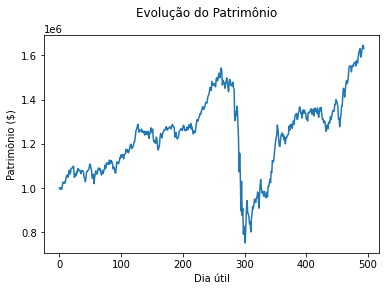

Patrimônio final obtido por agente DDPG: R$1630974.2631516757


In [21]:
%matplotlib inline
fig = plt.figure()
ax = fig.gca()

ax.plot(portifolio_value)
fig.suptitle('Evolução do Patrimônio')
ax.set_xlabel('Dia útil')
ax.set_ylabel('Patrimônio ($)')
plt.show()

print("Patrimônio final obtido por agente DDPG: R$" + str(portifolio_value[-1]))

Como baseline, será rodado um teste com mesmo portifólio inicial, mas usando os retornos que o IBOVESPA deu no mesmo período

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (494, 8)


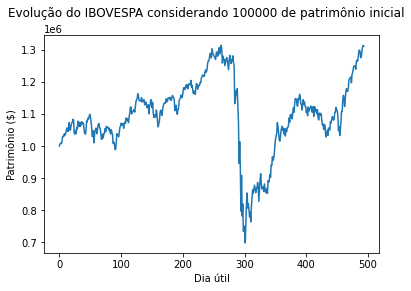

Patrimônio final considerando evolução do ibovespa: R$1310882.0814837604


In [22]:

DF_IBOV = YahooDownloader(start_date = '2019-01-01',
                     end_date = '2021-01-01',
                     ticker_list = ['^BVSP']).fetch_data()

DF_IBOV_LIST = np.array(DF_IBOV[['close']].values.tolist())*(1000000/91012)

fig = plt.figure()
ax = fig.gca()

ax.plot(DF_IBOV_LIST)
fig.suptitle('Evolução do IBOVESPA considerando 100000 de patrimônio inicial')
ax.set_xlabel('Dia útil')
ax.set_ylabel('Patrimônio ($)')
plt.show()

print("Patrimônio final considerando evolução do ibovespa: R$" + str(DF_IBOV_LIST[-1][0]))

Por fim um gráfico comparando a performance de ambos

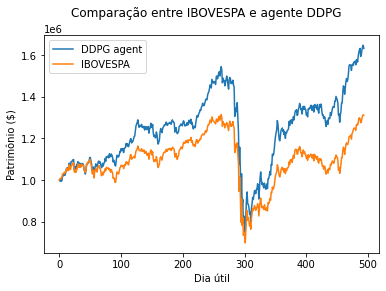

diferença de ganhos entre o robô trader e o IBOVESPA: R$320092.1816679153


In [23]:
fig = plt.figure()
ax = fig.gca()

ax.plot(portifolio_value, label='DDPG agent')
ax.plot(DF_IBOV_LIST, label='IBOVESPA')
fig.suptitle('Comparação entre IBOVESPA e agente DDPG')
ax.set_xlabel('Dia útil')
ax.set_ylabel('Patrimônio ($)')
plt.legend(loc='best')
plt.show()

print('diferença de ganhos entre o robô trader e o IBOVESPA: R$' +str((portifolio_value[-1]-DF_IBOV_LIST[-1])[0]))